In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [8]:
zip_file_path = 'archive (1).zip'  
extracted_folder = '/content/dataset/'  
if not os.path.exists(extracted_folder):
    os.makedirs(extracted_folder)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print(f"Files extracted to {extracted_folder}")

Files extracted to /content/dataset/


In [3]:
TRAIN_DIR = '/content/dataset/train'  
TEST_DIR = '/content/dataset/test'   

In [6]:
def load_dataset(directory):
    images = []
    labels = []
    for label in os.listdir(directory):  
        sub_dir = os.path.join(directory, label) 
        if os.path.isdir(sub_dir): 
            for filename in os.listdir(sub_dir):  
                file_path = os.path.join(sub_dir, filename) 
                img = cv2.imread(file_path)  
                if img is not None:
                    images.append(img)
                    labels.append(label)  
    return images, labels


In [ ]:

train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)

test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)

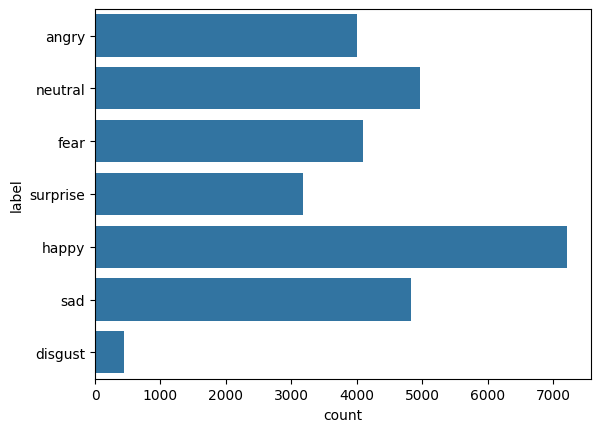

In [13]:
# Visualize data
sns.countplot(train['label'])
img = Image.fromarray(train['image'][0])

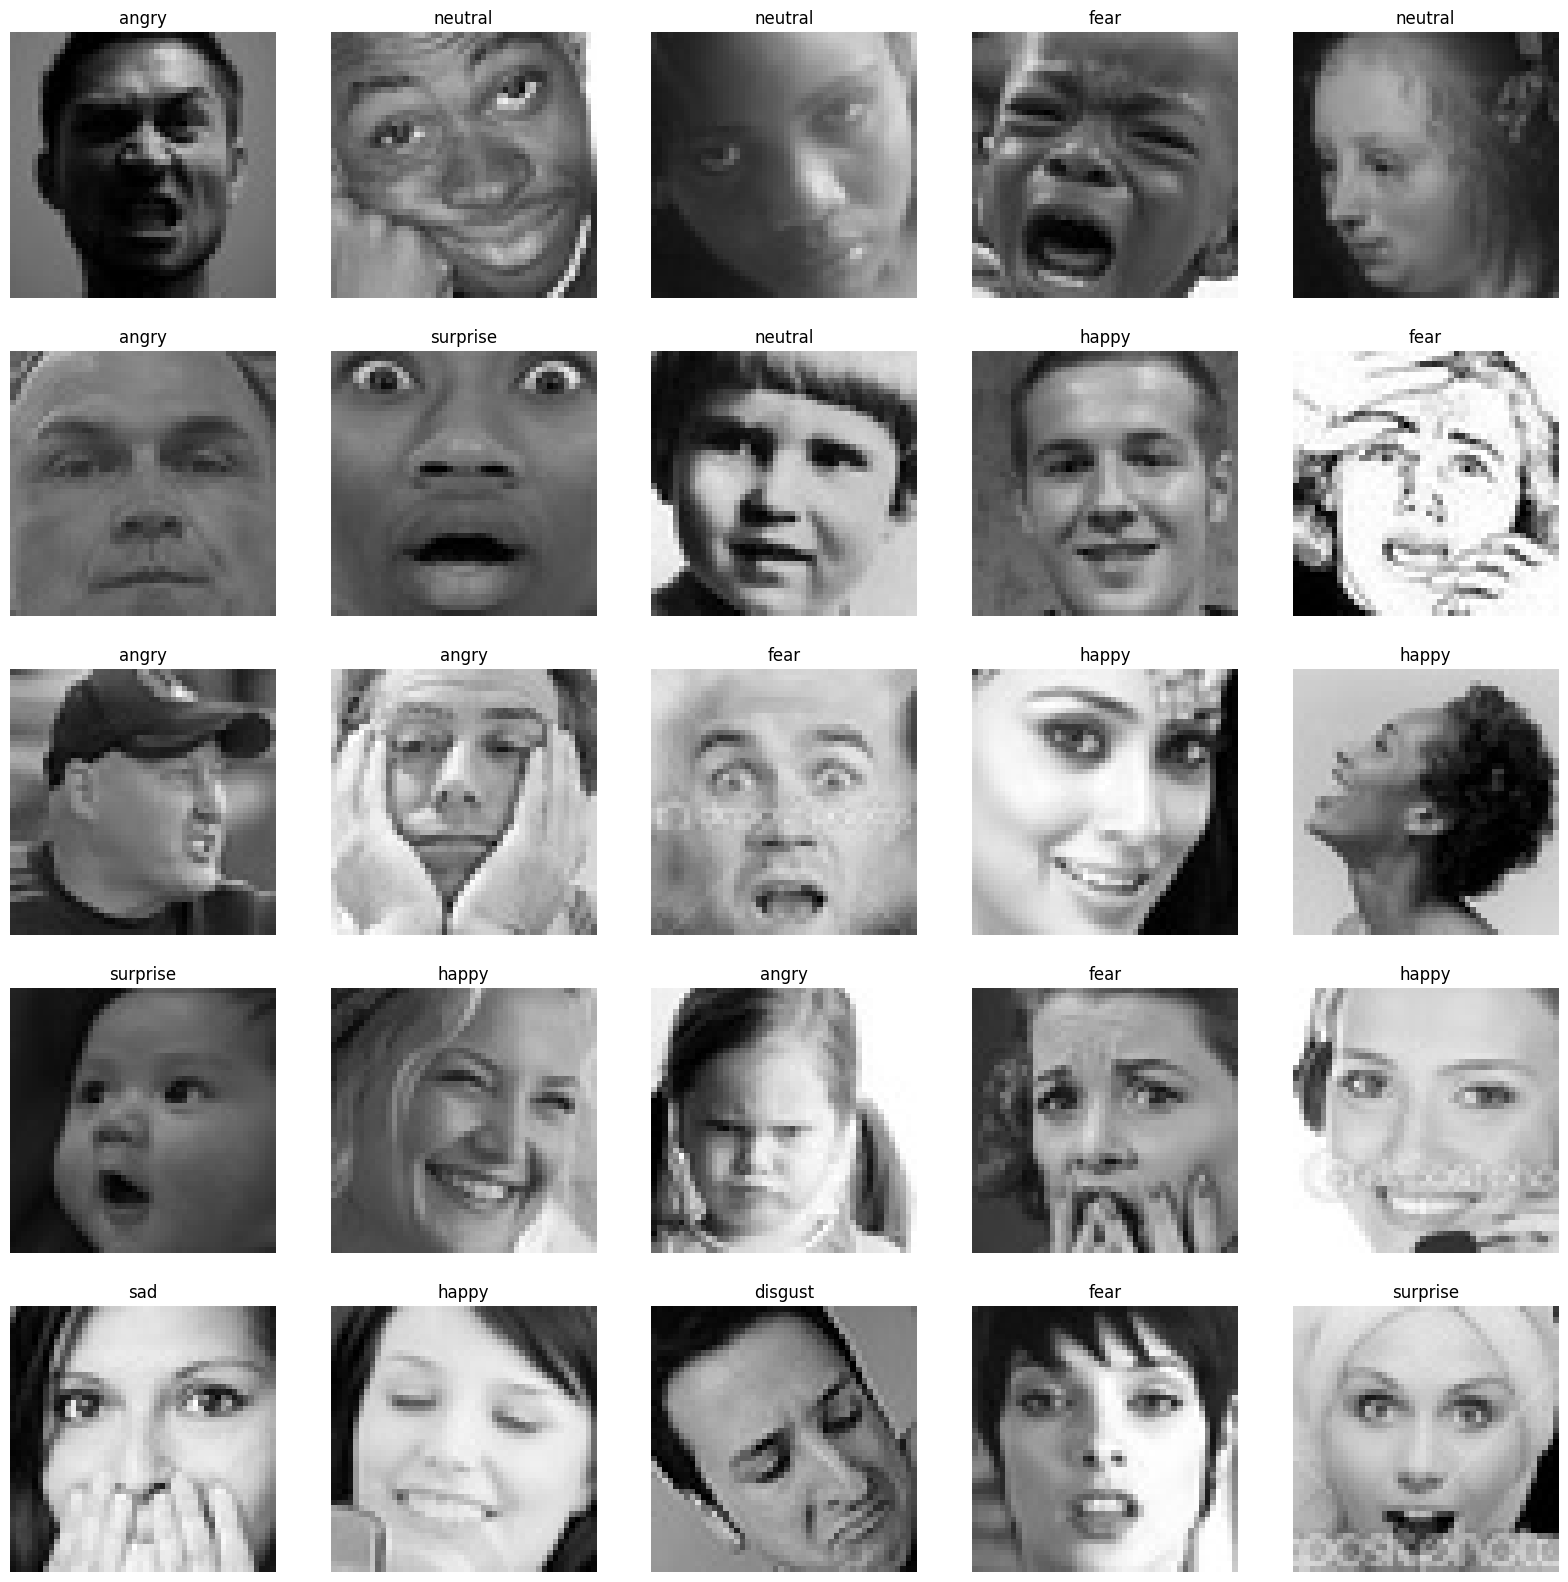

In [14]:
# Display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')
    

In [15]:
# Feature extraction
def extract_features(images):
    features = []
    for image in tqdm(images):
        img_resized = cv2.resize(image, (48, 48))
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_resized = np.expand_dims(img_resized, axis=-1)
        features.append(img_resized)
    return np.array(features)

train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

100%|███████████████████████████████████████████████████████████████████████████| 7178/7178 [00:00<00:00, 31255.77it/s]


In [16]:
# Normalize the image data
x_train = train_features / 255.0
x_test = test_features / 255.

In [17]:
# Encode labels
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
# Model configuration
input_shape = (48, 48, 1)
output_class = 7

In [19]:
# Building the CNN model
model = Sequential()

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.2438 - loss: 1.8350 - val_accuracy: 0.2471 - val_loss: 1.8165
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.2508 - loss: 1.8062 - val_accuracy: 0.2640 - val_loss: 1.7567
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.2852 - loss: 1.7338 - val_accuracy: 0.3656 - val_loss: 1.6224
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.3572 - loss: 1.6140 - val_accuracy: 0.4352 - val_loss: 1.4576
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.4160 - loss: 1.4999 - val_accuracy: 0.4670 - val_loss: 1.3721
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.4452 - loss: 1.4307 - val_accuracy: 0.4882 - val_loss: 1.3351
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.4672 - loss: 1.3842 - val_accuracy: 0.5049 - val_loss: 1.2695
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.4798 - loss: 1.3532 - val_accu

In [ ]:
# Plotting accuracy and loss graphs 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [33]:
# Random test prediction
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Output: surprise


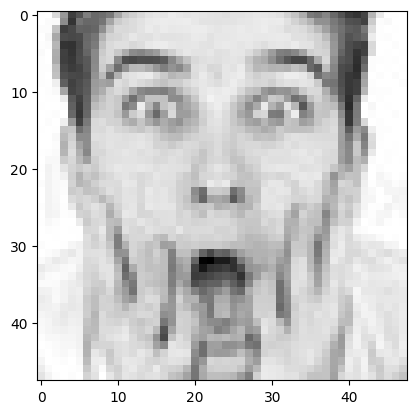

In [34]:
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')

In [26]:
model.save('IDS_Project_model.h5')